In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv, norm

# Practical MIMO detection schemes

In [12]:
 # Generate complex-valued noise
def gen_noise(N, snr_db):
    # Do not forget np.sqrt(1/2) factor for CN circular noise!
    sigma = np.sqrt(1 / (2 * 10 ** (snr_db / 10)))
    z_re = np.random.normal(0, 1, size=(N,))
    z_im = np.random.normal(0, 1, size=(N,))
    return (z_re + 1j * z_im) * sigma  # The total power is 2 * sigma^2


def simulate(snr_db_range, max_errors, experiment_func):
    p_e = np.zeros(snr_db_range.shape)
    n_points = p_e.shape[0]
    # Run simulations:
    for i in range(n_points):
        snr_db = snr_db_range[i]
        n_errors = 0.0
        n_experiments = 0.0
        np.random.seed(0)
        while n_errors < max_errors:
            n_errors += experiment_func(snr_db)
            n_experiments += 1
        p_e[i] = n_errors / n_experiments
    # Plot results:
    plt.plot(snr_db_range, p_e)
    plt.yscale('log')
    plt.xlabel('Signal-to-noise ratio [dB]')
    plt.ylabel('Error rate')
    plt.grid()
    # Hide plt.show() to add more data on a single figure
    # plt.show()

### MIMO channel routines
* Use np.matrix() and matrix (not element-wise with proadcasting) multiplication

$$
\underset{N_R\times 1}{y} = \underset{N_R\times N_T}{H}\times\underset{N_T\times 1}{x} +\underset{N_R\times 1}{z} 
$$

where $N_R$ - number of receiver antennas, $N_T$ - number of transmitting antennas.

Consider BPSK: $0 \rightarrow 1,\;\;1 \rightarrow -1$

In [13]:
def get_H_rayleigh(n_tx, n_rx):
    return np.matrix(np.random.randn(n_rx, n_tx) + 1j * np.random.randn(n_rx, n_tx)) / np.sqrt(2 * n_tx)


# BPSK V-BLAST transmitter, CSI known at receiver only - equal power allocation
def generate_received_signal(n_tx, n_rx, snr_db):
    H = get_H_rayleigh(n_tx, n_rx)
    x = np.random.randint(0, 2, size=n_tx,)
    y = H * np.matrix(1 - 2 * x).T + np.matrix(gen_noise(n_rx, snr_db)).T
    return x, y, H

## Maximum likelihood MIMO detection routines

$$
\newcommand\norm[1]{\left\lVert#1\right\rVert}
\hat{x} = argmin \norm{y - Hx}^2 
$$

In [14]:
# Convert integer to binary array
def de2bi(val, out_len):
    val_array = [int(x) for x in list('{0:1b}'.format(val))]
    return [0] * (out_len - len(val_array)) + val_array

# Generate 2**N possible transmitted combinations
def gen_iwd_book(N):
    n_cwd = 2 ** N
    iwd_book = np.zeros((2 ** N, N))
    for i in range(n_cwd):
        iwd_book[i, :] = de2bi(i, N)
    return iwd_book


# Find the closest point to the received signal among all possible
# combinations transmitted
def ml_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)

    iwd_book = gen_iwd_book(n_tx)
    iwd_book_bpsk = np.matrix(1 - 2 * iwd_book).T

    y_vec = H * iwd_book_bpsk
    distance = np.linalg.norm(y_vec - y, axis=0) ** 2
    iwd_best_id = np.argmin(distance)
    x_hat = iwd_book[iwd_best_id, :]
    return np.mean(x_hat != x)

## MRC - Maximum Ratio Combining (matched filter)

$$
\underset{N_T\times 1}{\hat{x}} = \underset{N_T\times N_R}{G} \times \underset{N_R\times 1}{y}
$$

$$
\underset{N_T\times N_R}{G} = \underset{N_T\times N_R}{H^*}
$$

In [15]:
def mrc_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)

    G = H.H
    
    x_hat = ((G * y).real < 0).astype(int).T

    return np.mean(x_hat != x)

## ZF - Zero Forcing (mean squared error, decorrelator)

$$
\underset{N_T\times 1}{\hat{x}} = \underset{N_T\times N_R}{G} \times \underset{N_R\times 1}{y}
$$

$$
\underset{N_T\times N_R}{G} = \big( \underset{N_T\times N_R}{H^*} \times \underset{N_R\times N_T}{H}\big)^{-1} \underset{N_T\times N_R}{H^*}
$$

In [16]:
def zf_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)

    G = inv(H.H * H) * H.H
    
    x_hat = ((G * y).real < 0).astype(int).T

    return np.mean(x_hat != x)



## MMSE - Minimum Mean Square Error

$$
\underset{N_T\times 1}{\hat{x}} = \underset{N_T\times N_R}{G} \times \underset{N_R\times 1}{y}
$$

$$
\underset{N_T\times N_R}{G} = \underset{N_T\times N_R}{H^*} \big[\underset{N_R\times N_T}{H}\times\underset{N_T\times N_R}{H^*}+N_0 \underset{N_R\times N_R}{I}  \big] ^{-1}
$$

where $N_0$ - spectral noise power density

In [17]:
def mmse_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)

    sigma = np.sqrt(1 / (2 * 10 ** (snr_db / 10)))
    I_N = np.identity(n_rx) * 2 * (sigma ** 2)
    G = H.H * inv(H*H.H + I_N)
    
    x_hat = ((G * y).real < 0).astype(int).T
    
    return np.mean(x_hat != x)



## MMSE-SIC - Minimum Mean Square Error, Successive interference cancellation

$$
\underset{N_T\times N_R}{G} = \underset{N_T\times N_R}{H^*} \big[\underset{N_R\times N_T}{H}\times\underset{N_T\times N_R}{H^*}+N_0 \underset{N_R\times N_R}{I}  \big] ^{-1}
$$

$$
\underset{N_R\times 1}{y} = \underset{N_R\times N_T}{H}\times\underset{N_T\times 1}{x} +\underset{N_R\times 1}{z}
$$





<center>
$h_i$ - columns of $H$:
</center>

$$
\underset{N_R\times N_T}{H} = \big[
\underset{N_R\times 1}{h_1} \; \underset{N_R\times 1}{h_2} \;\ldots\; \underset{N_R\times 1}{h_{N_T}}
\big]
$$

$$
y = h_k x_k+\sum_{i=1,i\neq k}^{N_t}h_i x_i + z
$$

<center>
$g_k$ - rows of $G$:
</center>

$$
\underset{N_R\times N_T}{G^T} = \big[
\underset{N_R\times 1}{g_1^T} \; \underset{N_R\times 1}{g_2^T} \;\ldots\; \underset{N_R\times 1}{g_{N_T}^T}
\big]
$$

$$
\hat{x}_k = \underset{1 \times N_R}{g_k} \times \underset{N_R\times 1}{y} = \underbrace{g_k h_k}_{\sqrt{P_R}} x_k + \underbrace{\sum_{i=1,i\neq k}^{N_t}g_k h_i}_{\sqrt{P_I}} x_i + \underbrace{g_k z}_{\sqrt{P_N}}
$$

where $P_R$ - signal power, $P_I$ - interference power, $P_N$ - noise power.

Thus, Signal to Interference + Noise Ratio (SINR) for symbol $k$:
$$SINR = \frac{P_R}{P_I+P_N}$$

The idea of successive noise cancellation is the following:

1) find $k$ for which SINR is the maximum

2) decode $k$-th symbol:
$
\hat{x}_k = g_k y 
$

3) cancel interference from $k$-th symbol: $\hat{y} = y - \hat{x}_k h_k$

4) Drop $k$-th column from $H$ and recompute $G$

5) repeat steps 1-4 untill all symbols are decoded

In [18]:
def mmse_sic_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)

    N0 = 1 / (10 ** (snr_db / 10))
    I_N = np.identity(n_rx) * N0

    x_hat = np.zeros((n_tx,))
    is_x_hat_k_full = np.zeros((n_tx,)).astype(bool)

    for iteration in range(n_tx):
        G = H.H * inv(H*H.H + I_N)
        
        n_symbols = n_tx - iteration
        
        SINR = np.zeros((n_symbols,))
        for k in range(n_symbols):
            g_k = G[k]
            P_N = N0 * (norm(g_k) ** 2)
            P_I = 0
            for i in range(n_symbols):
                h_i = H[:,i]
                if i == k:
                    P_R = norm(g_k*h_i) ** 2
                else:
                    P_I += norm(g_k*h_i) ** 2

            SINR[k] = P_R / (P_I + P_N)

        k = np.argmax(SINR)

        g_k = G[k]
        x_hat_k = ((g_k * y).real < 0).astype(int)

        y = y - (1 - 2 * np.mean(x_hat_k)) * H[:,k] # interference cancellation

        # drop k-th column in H and row in G
        left = np.ones((n_symbols,)).astype(bool)
        left[k] = False
        H = H[:,left]
        G = G[left,:]
        
        absolute_k = k
        p = 0
        for j in range(k+1):
            while is_x_hat_k_full[p]:
                absolute_k += 1
                p += 1
            p += 1

        is_x_hat_k_full[absolute_k] = True
        x_hat[absolute_k] = x_hat_k

    return np.mean(x_hat != x)

## Numerical experiments

Evaluating the MMSE-SIC detector
Evaluating the ML detector
Evaluating the ZF detector
Evaluating the MMSE detector
Evaluating the MRC detector


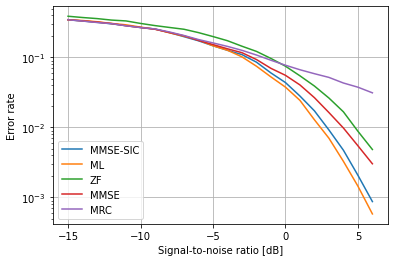

In [25]:
snr_range = np.arange(-15, 7)
n_tx = 4  # Transmitter antenna count
n_rx = 8  # Receiver antenna count

n_errors = 100 # Maximum number of errors

print('Evaluating the MMSE-SIC detector')
simulate(snr_range, n_errors,
    lambda x: mmse_sic_detector(x, n_tx, n_rx)
)

print('Evaluating the ML detector')
simulate(snr_range, n_errors,
    lambda x: ml_detector(x, n_tx, n_rx)
)

print('Evaluating the ZF detector')
simulate(snr_range, n_errors,
    lambda x: zf_detector(x, n_tx, n_rx)
)

print('Evaluating the MMSE detector')
simulate(snr_range, n_errors,
    lambda x: mmse_detector(x, n_tx, n_rx)
)

print('Evaluating the MRC detector')
simulate(snr_range, n_errors,
    lambda x: mrc_detector(x, n_tx, n_rx)
)

plt.legend(['MMSE-SIC', 'ML', 'ZF', 'MMSE', 'MRC'])